## Imports

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mrmr import mrmr_classif
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, RFE, f_classif
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import catboost as cb
from sklearn.model_selection import cross_val_score, cross_validate
import xgboost as xgb

## Load data

In [297]:
# X = pd.read_csv("species_relative_abundance.csv", sep=";")
X = pd.read_csv("genus_features.csv", sep=";")
y = pd.read_csv("../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Label"]
X = X.set_index("Sample", drop=True)
print(X.shape)
assert X.shape[0] == y.shape[0]

(121, 1128)


## PCA

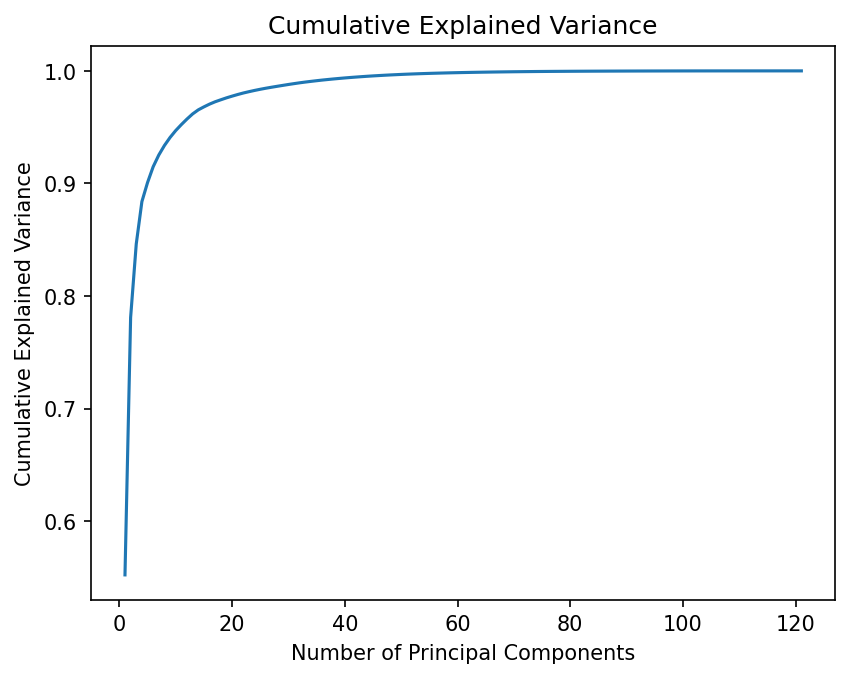

In [364]:
# Perform PCA
pca = PCA(random_state=42)
pca.fit(X)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig = plt.figure(dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Split the data into training and testing

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

## Features selection

### Number of features to select

In [299]:
num_features_to_select = 100

### XGBoost

In [300]:
# Train the XGBoost classifier
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Get feature importance scores
importance_scores = model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores})

# Sort features based on importance score in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).iloc[:num_features_to_select]

# Select top K features based on importance scores
xgboost_top_k_features = feature_importances['Feature'][:num_features_to_select].tolist()

### Select K Best (SKB) IG

In [306]:
# Create an instance of SelectKBest with mutual_info_classif as the scoring function
ig_selector = SelectKBest(score_func=mutual_info_classif, k=num_features_to_select)

# Fit the ig_selector to the data
ig_selector.fit(X, y)

# Get the scores and indices of the selected features
feature_scores = ig_selector.scores_
feature_indices = ig_selector.get_support(indices=True)

# Create a DataFrame to store feature names and their scores
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Score': feature_scores})

# Sort features based on their scores in descending order
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Select the top K features based on scores
ig_top_k_features = feature_scores_df['Feature'][:num_features_to_select].tolist()

### Select K Best (SKB) ANOVA

In [307]:
# Create an instance of SelectKBest with mutual_info_classif as the scoring function
anova_selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit the ig_selector to the data
anova_selector.fit(X, y)

# Get the scores and indices of the selected features
feature_scores = anova_selector.scores_
feature_indices = anova_selector.get_support(indices=True)

# Create a DataFrame to store feature names and their scores
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Score': feature_scores})

# Sort features based on their scores in descending order
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Select the top K features based on scores
anova_top_k_features = feature_scores_df['Feature'][:num_features_to_select].tolist()

### MRMR

In [301]:
mrmr_top_k_features = mrmr_classif(X=X, y=y, K=num_features_to_select)

100%|██████████| 100/100 [00:08<00:00, 11.31it/s]


### RFE Logistic Regression

In [371]:
# Create the estimator (e.g., Logistic Regression)
estimator = LogisticRegression()

# Perform RFE to select top k features
rfe = RFE(estimator, n_features_to_select=num_features_to_select)
X_selected = rfe.fit_transform(X, y)

# Get the indices of the selected features
feature_indices = rfe.get_support(indices=True)

# Get the names of the selected features
rfe_logreg_top_k_features = X.columns[feature_indices].to_list()

In [305]:
np.intersect1d(xgboost_top_k_features, ig_top_k_features)

NameError: name 'ig_top_k_features' is not defined

## Models training

In [310]:
# split and upsample minority class in the training set
smote = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X[ig_top_k_features], y, test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### XGBoost

Accuracy: 0.6
Best score: 0.856084656084656
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        16
           1       0.43      0.33      0.38         9

    accuracy                           0.60        25
   macro avg       0.55      0.54      0.54        25
weighted avg       0.58      0.60      0.59        25

Area under the curve 0.5416666666666666


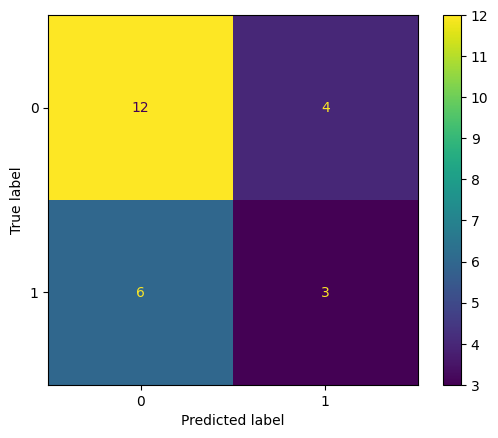

{'xgboost__max_depth': 5,
 'xgboost__max_leaves': 0,
 'xgboost__n_estimators': 100}

In [311]:
# Define the Pipeline
xgboost_pipeline = Pipeline([
  # ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
  ('xgboost', xgb.XGBClassifier(random_state=42))  # Step 4: Random Forest
])
xgboost_param_grid = {
  'xgboost__n_estimators': [1, 5, 10, 15, 20, 25, 30, 50, 100, 150, 200],  # Step 4: grid search for n_estimators
  'xgboost__max_depth': [1, 5, 10, 15, 20, 25, 30, 50, 100, 150, 200],  # Step 4: grid search for n_estimators
  'xgboost__max_leaves': [0, 1, 5, 10],  # Step 4: grid search for n_estimators
}

# Define the GridSearchCV object
xgboost_grid_search = GridSearchCV(xgboost_pipeline, param_grid=xgboost_param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
xgboost_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator and make predictions on the testing data
best_estimator = xgboost_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found xg
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best score:", xgboost_grid_search.best_score_)
# Compute accuracy for the best found xg
report = classification_report(y_test, y_pred)
# pd.DataFrame(report).T.to_csv("best_model_xgboost_classification_report.csv", sep=";")
params = xgboost_grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
xgboost_grid_search.best_params_

In [316]:
xgboost_grid_search.cv_results_

{'mean_fit_time': array([0.0074193 , 0.01036477, 0.0170908 , 0.0201117 , 0.02412605,
        0.03715134, 0.06388216, 0.09638   , 0.15850778, 0.2255352 ,
        0.28715477, 0.01535635, 0.021912  , 0.03768358, 0.04182649,
        0.05892777, 0.06245313, 0.06743503, 0.09576678, 0.16919851,
        0.22703357, 0.23959904, 0.01519856, 0.01979108, 0.02330976,
        0.02931309, 0.03745337, 0.04143081, 0.04678411, 0.06946301,
        0.11828132, 0.16091857, 0.20934978, 0.01424384, 0.01826177,
        0.02606597, 0.02960153, 0.03502164, 0.04168477, 0.04680314,
        0.06727648, 0.11618524, 0.17632575, 0.20620375, 0.01619978,
        0.02700853, 0.03966103, 0.05007014, 0.06111779, 0.07131643,
        0.07964597, 0.10348577, 0.15488806, 0.18799639, 0.22916961,
        0.01581893, 0.02629786, 0.04177437, 0.05145078, 0.06490283,
        0.07677474, 0.08604865, 0.09975758, 0.15885849, 0.19421902,
        0.23489537, 0.01727858, 0.0276762 , 0.03947649, 0.05432677,
        0.06198621, 0.06650496,

### AdaBoost

Accuracy: 0.68
Best score: 0.8412698412698412
              precision    recall  f1-score   support

           0       0.79      0.69      0.73        16
           1       0.55      0.67      0.60         9

    accuracy                           0.68        25
   macro avg       0.67      0.68      0.67        25
weighted avg       0.70      0.68      0.69        25

Area under the curve 0.6770833333333333


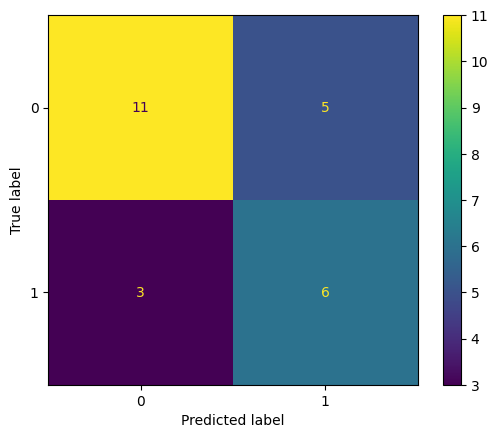

{'adaboost__algorithm': 'SAMME.R',
 'adaboost__learning_rate': 0.7,
 'adaboost__n_estimators': 150}

In [696]:
# Define the Pipeline
ada_pipeline = Pipeline([
    # ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('adaboost', AdaBoostClassifier(random_state=42))  # Step 4: Random Forest
])
ada_param_grid = {
    'adaboost__n_estimators': [1, 5, 10, 15, 20, 25, 30, 50, 100, 150, 200],  # Step 4: grid search for n_estimators
    'adaboost__algorithm' :['SAMME', 'SAMME.R'], # Step 4: grid search for criterion
    'adaboost__learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] # Step 4: grid search for number of max_features
}

# Define the GridSearchCV object
ada_grid_search = GridSearchCV(ada_pipeline, param_grid=ada_param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
ada_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator and make predictions on the testing data
best_estimator = ada_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found ada
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best score:", ada_grid_search.best_score_)
# Compute accuracy for the best found ada
report = classification_report(y_test, y_pred)
# pd.DataFrame(report).T.to_csv("best_model_ada_classification_report.csv", sep=";")
params = ada_grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
ada_grid_search.best_params_

### Random Forest

Accuracy: 0.76
Best score: 0.8446575003096741
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        16
           1       0.71      0.56      0.63         9

    accuracy                           0.76        25
   macro avg       0.75      0.72      0.72        25
weighted avg       0.75      0.76      0.75        25

Area under the curve 0.7152777777777778


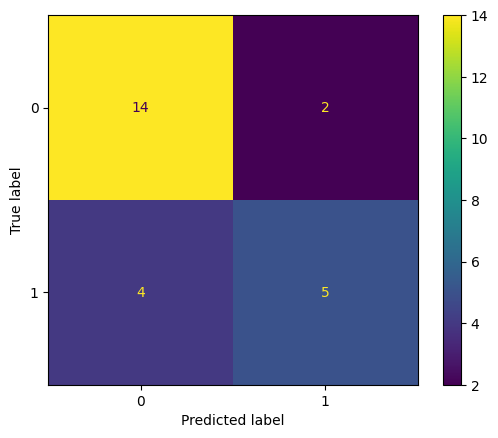

{'rf__criterion': 'entropy',
 'rf__max_depth': 10,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 25}

In [782]:
# Define the Pipeline
rf_pipeline = Pipeline([
    # ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('rf', RandomForestClassifier(random_state=42, warm_start=True))  # Step 4: Random Forest
])
rf_param_grid = {
    'rf__n_estimators': [1, 5, 10, 15, 20, 25],  # Step 4: grid search for n_estimators
    'rf__max_depth': [1, 5, 10, 15, 20, None],  # Step 4: grid search for max_depth
    'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
    'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
}

# Define the GridSearchCV object
rf_grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    n_jobs=-1,
    refit='f1',
    scoring=['f1', 'accuracy', 'roc_auc'],
)

# Fit the GridSearchCV object on the training data
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator and make predictions on the testing data
best_estimator = rf_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best score:", rf_grid_search.best_score_)
# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred)
# pd.DataFrame(report).T.to_csv("best_model_rf_classification_report.csv", sep=";")
params = rf_grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
rf_grid_search.best_params_

## Perfomance plots

        Model    Metric     Score                                    Features
0          RF       AUC  0.430556                     MRMR (Top 100 features)
1          RF        F1  0.000000                     MRMR (Top 100 features)
2          RF  Accuracy  0.692308                     MRMR (Top 100 features)
3          RF       AUC  0.281250                     MRMR (Top 100 features)
4          RF        F1  0.000000                     MRMR (Top 100 features)
..        ...       ...       ...                                         ...
115  AdaBoost        F1  0.000000  RFE logistic regression (Top 100 features)
116  AdaBoost  Accuracy  0.750000  RFE logistic regression (Top 100 features)
117  AdaBoost       AUC  0.259259  RFE logistic regression (Top 100 features)
118  AdaBoost        F1  0.222222  RFE logistic regression (Top 100 features)
119  AdaBoost  Accuracy  0.416667  RFE logistic regression (Top 100 features)

[120 rows x 4 columns]


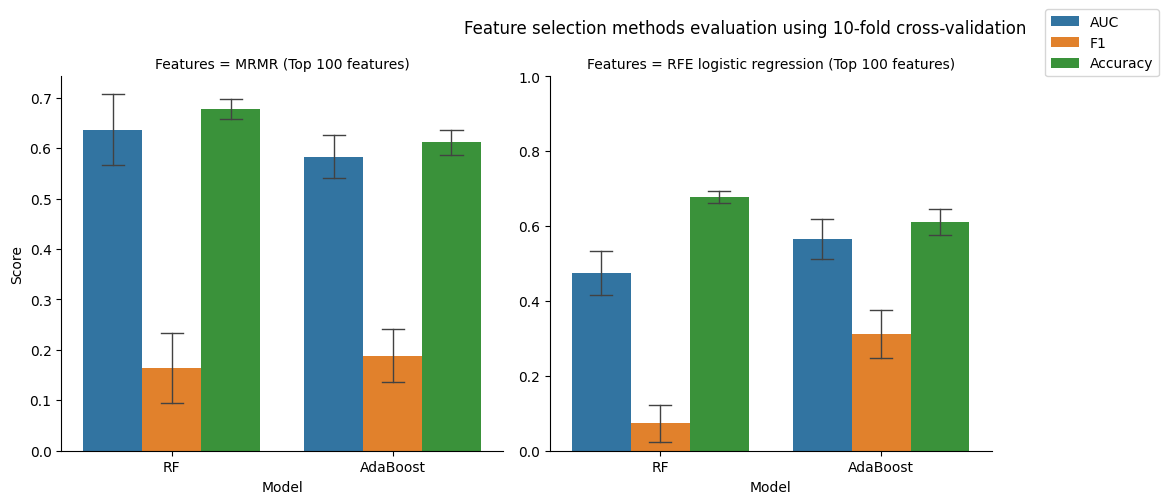

In [801]:
def run_cv_on_estimator(estimator, features, n_cv=10, metrics=('f1', 'accuracy', 'roc_auc')):
    if features == "":
        return cross_validate(estimator, X, y, cv=n_cv, scoring=metrics)
    else:
        return cross_validate(estimator, X[features], y, cv=n_cv, scoring=metrics)

def train_model_on_features(estimator, features):
    pass
        
    
def plot_metrics(features, estimators, label="", n_cv=10):
    # get the names of all the estimators passed to the function
    estimator_names = list(estimators.keys())
    # create an empty dataframe
    df = pd.DataFrame(columns=['Model', 'Metric', 'Score', "Features"])
    # run cross-validation on all features and estimators
    # TODO create function to also train estimators on the given feature subsets
    for name, estimator in estimators.items():
        for feature_name, feature in features.items():
            tmp_cv_results = run_cv_on_estimator(estimator=estimator, features=feature, n_cv=n_cv)
            for i in range(n_cv):
                df = pd.concat([df, pd.DataFrame([{'Model': name, 'Metric': 'AUC', 'Score': tmp_cv_results['test_roc_auc'][i], 'Features': feature_name}])], ignore_index=True)
                df = pd.concat([df, pd.DataFrame([{'Model': name, 'Metric': 'F1', 'Score': tmp_cv_results['test_f1'][i], 'Features': feature_name}])], ignore_index=True)
                df = pd.concat([df, pd.DataFrame([{'Model': name, 'Metric': 'Accuracy', 'Score': tmp_cv_results['test_accuracy'][i], 'Features': feature_name}])], ignore_index=True)
    print(df)
    g = sns.catplot(
        data=df,
        x='Model',
        y='Score',
        hue='Metric',
        col='Features',
        estimator=np.mean,
        kind='bar',
        errorbar='se',
        capsize=0.1,
        errwidth=1,
        col_wrap=3,
        legend=False,
        # disable sharing of x axis markings
        sharex=False,
        # disable sharing of y axis markings
        sharey=False,
    )
    g.fig.subplots_adjust(top=0.9) # adjust the Figure in g
    g.fig.suptitle(f'Feature selection methods evaluation using {n_cv}-fold cross-validation')
    g.fig.tight_layout()
    g.tick_params(labelbottom=True)
    plt.ylim(0, 1)
    # plt.legend(loc='center right')
    plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0, loc='lower center')

plot_metrics(
    features={
        f"MRMR (Top {num_features_to_select} features)": mrmr_top_k_features,
        # f"IG (Top {num_features_to_select} features)": ig_top_k_features,
        # f"ANOVA (Top {num_features_to_select} features)": anova_top_k_features,
        # f"XGBoost (Top {num_features_to_select} features)": xgboost_top_k_features,
        f"RFE logistic regression (Top {num_features_to_select} features)": rfe_logreg_top_k_features,
        # f"All features":  ""
    },
    estimators={
        "RF": rf_grid_search.best_estimator_,
        "AdaBoost": ada_grid_search.best_estimator_,
        # "XGBoost": xgboost_grid_search.best_estimator_,
    },
    label="MRMR (Top 100 features)",
    n_cv=10
)

# (Experimental!!!) Class thingy for feature selection algo evaluation

## Feature selection algorithms classes

In [325]:
from sklearn.base import BaseEstimator, TransformerMixin
from skfeature.function.statistical_based import f_score as ANOVA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
from mrmr import mrmr_classif
from sklearn.linear_model import Lasso

class XGBoostFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, k=100, **kwargs):
        self.estimator = XGBClassifier(**kwargs)
        self.k = k
    
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
    
    def transform(self, X):
        if self.k is not None:
            feature_importances = self.estimator.feature_importances_
            top_k_indices = feature_importances.argsort()[-self.k:]
            return X.iloc[:, top_k_indices]
        else:
            return X
    
    def get_support(self, indices=False):
        if self.k is not None:
            feature_importances = self.estimator.feature_importances_
            top_k_indices = feature_importances.argsort()[-self.k:]
            if indices:
                return top_k_indices
            else:
                support = np.zeros_like(feature_importances, dtype=bool)
                support[top_k_indices] = True
                return support
        else:
            return np.ones(X.shape[1], dtype=bool)

class ANOVAFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, k=100, **kwargs):
        self.selector = SelectKBest(score_func=f_classif, k=k)
        self.k = k
    
    def fit(self, X, y):
        self.selector.fit(X, y)
        return self
    
    def transform(self, X):
        return self.selector.transform(X)
    
    def get_support(self, indices=False):
        return self.selector.get_support(indices=indices)

class Chi2FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, k=100, **kwargs):
        self.selector = SelectKBest(score_func=chi2, k=k)
        self.k = k
    
    def fit(self, X, y):
        self.selector.fit(X, y)
        return self
    
    def transform(self, X):
        return self.selector.transform(X)
    
    def get_support(self, indices=False):
        return self.selector.get_support(indices=indices)

class InformationGainFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, k=100, **kwargs):
        self.selector = SelectKBest(score_func=mutual_info_classif, k=k)
        self.k = k
    
    def fit(self, X, y):
        self.selector.fit(X, y)
        return self
    
    def transform(self, X):
        return self.selector.transform(X)
    
    def get_support(self, indices=False):
        # print(self.selector.get_support(indices=True))
        return self.selector.get_support(indices=indices)

class MRMRFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, k=100, **kwargs):
        self.k = k
    
    def fit(self, X, y):
        self.selected_features = mrmr_classif(X=X, y=y, K=self.k, show_progress=False)
        return self
    
    def transform(self, X):
        return X[self.selected_features]

    def get_support(self, indices=False):
        return self.selected_features if indices else None

class LassoFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=1.0, k=100, **kwargs):
        self.alpha = alpha
        self.lasso = None
        self.selected_features = None
        self.k = k

    def fit(self, X, y):
        self.lasso = Lasso(alpha=self.alpha)
        self.lasso.fit(X, y)
        # self.selected_features = np.where(self.lasso.coef_ != 0)[0]
        # print(self.lasso.coef_)
        # print(self.selected_features)
        self.selected_features = self.lasso.coef_.argsort()[-self.k:]

    def transform(self, X):
        return X.iloc[:, self.selected_features]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

    def get_support(self, indices=False):
        if indices:
            return self.selected_features
        else:
            mask = np.zeros_like(self.lasso.coef_, dtype=bool)
            mask[self.selected_features] = True
            return mask

class RFEFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, base_estimator, k=100):
        self.base_estimator = base_estimator
        self.k = k
        self.rfe_selector = None

    def fit(self, X, y):
        self.rfe_selector = RFE(estimator=self.base_estimator, n_features_to_select=self.k)
        self.rfe_selector.fit(X, y)
        return self

    def transform(self, X):
        if self.rfe_selector is None:
            raise ValueError("RFEFeatureSelection is not fitted.")
        return self.rfe_selector.transform(X)

    def get_support(self, indices=False):
        if self.rfe_selector is None:
            raise ValueError("RFEFeatureSelection is not fitted.")
        if indices:
            return self.rfe_selector.get_support(indices=True)
        else:
            return self.rfe_selector.get_support()

## Main class

In [327]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class FeatureSelectionRandomizedSearch:
    def __init__(self, classifiers, param_distributions, feature_selection_algorithms=None, metrics=None, test_size=0.2, use_smote=False, num_features=None, n_cv=5, n_iter=10, scoring=None):
        self.classifiers = classifiers
        self.param_distributions = param_distributions
        self.feature_selection_algorithms = feature_selection_algorithms
        self.metrics = metrics
        self.results = {}
        self.test_size = test_size
        self.use_smote = use_smote
        self.num_features = num_features
        self.n_cv = n_cv
        self.n_iter = n_iter
        self.scoring = scoring
    
    def build_pipeline(self, classifier, feature_selection_algorithm=None):
        steps = []
        if feature_selection_algorithm is not None:
            steps.append(('feature_selection', feature_selection_algorithm))
        steps.append(('classification', classifier))
        return Pipeline(steps)
    
    def evaluate_metrics(self, pipeline, X, y):
        metric_scores = {}
        for metric in self.metrics:
            scores = cross_val_score(pipeline, X, y, cv=self.n_cv, scoring=metric)
            metric_scores[metric] = scores
        return metric_scores
    
    def fit(self, X, y):
        self.results = {}

        # Split the data into train and test sets
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=42)
        
        for clf_name, clf in self.classifiers.items():
            clf_results = {}
            for fs_name, fs_algorithm in self.feature_selection_algorithms.items():
                # Select top k features if num_features is specified
                # if self.num_features is not None:
                #     fs_algorithm.set_params(**{'k': self.num_features})
                #     fs_algorithm.fit(X, y)

                # Select top k features if num_features is specified
                # if self.num_features is not None:
                #     fs_algorithm.set_params(**{'k': self.num_features})
                #     fs_algorithm.fit(X_train, y_train)
                #     X_train = fs_algorithm.transform(X_train)
                #     X_test = fs_algorithm.transform(X_test)

                if fs_algorithm is not None:
                    fs_algorithm.set_params(**{'k': self.num_features})
                    fs_algorithm.fit(X, y)
                    X_train, X_test, y_train, y_test = train_test_split(fs_algorithm.transform(X), y, test_size=self.test_size, random_state=42)
                else:
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=42)

                
                # Build the pipeline
                # pipeline = self.build_pipeline(clf, fs_algorithm)
                pipeline = self.build_pipeline(clf)
                random_search = RandomizedSearchCV(pipeline, param_distributions=self.param_distributions[clf_name], n_iter=self.n_iter, cv=self.n_cv, random_state=42, n_jobs=-1, scoring=self.scoring)
                
                if self.use_smote:
                    # Apply SMOTE on the training data
                    smote = SMOTE()
                    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
                    random_search.fit(X_train_res, y_train_res)
                else:
                    random_search.fit(X_train, y_train)
                
                # Get the best estimator
                best_estimator = random_search.best_estimator_
                
                # Evaluate the metrics using cross-validation
                metric_scores = self.evaluate_metrics(best_estimator, X, y)
                
                # Store the results
                clf_results[fs_name] = {
                    'best_score': random_search.best_score_,
                    'best_estimator': best_estimator,
                    'metric_scores': metric_scores,
                    'selected_features': fs_algorithm.get_support(indices=True) if fs_algorithm else X.columns 
                }
            
            self.results[clf_name] = clf_results
    
    def get_best_params(self, classifier_name, feature_selection_name):
        return self.results.get(classifier_name, {}).get(feature_selection_name, {}).get('best_params')
    
    def get_best_score(self, classifier_name, feature_selection_name):
        return self.results.get(classifier_name, {}).get(feature_selection_name, {}).get('best_score')
    
    def get_metric_scores(self, classifier_name, feature_selection_name):
        return self.results.get(classifier_name, {}).get(feature_selection_name, {}).get('metric_scores')
    
    def get_selected_features(self, classifier_name, feature_selection_name):
        return self.results.get(classifier_name, {}).get(feature_selection_name, {}).get('selected_features')
    
    def plot_results(self):
        df = pd.DataFrame(columns=['Model', 'Metric', 'Score', 'Features'])

        for clf_name, clf_results in self.results.items():
            for fs_name, fs_result in clf_results.items():
                best_estimator = fs_result['best_estimator']
                metric_scores = fs_result['metric_scores']
                selected_features = fs_result['selected_features']

                for metric, scores in metric_scores.items():
                    # scores = np.concatenate(scores)  # Flatten the scores
                    for score in scores:
                        df = pd.concat([
                            df,
                            pd.DataFrame([{
                                'Model': clf_name,
                                'Metric': metric,
                                'Score': score,
                                'Features': f"{fs_name} (Top {self.num_features} features)" if self.feature_selection_algorithms[fs_name] else fs_name
                            }])],
                            ignore_index=True)

        # print(df)

        g = sns.catplot(
            data=df,
            x='Model',
            y='Score',
            hue='Metric',
            col='Features',
            estimator=np.mean,
            kind='bar',
            errorbar='se',
            capsize=0.1,
            errwidth=1,
            col_wrap=3,
            legend=False,
            sharex=False,
            sharey=False,
            legend_out=True
        )
        g.set(ylim=(0, 1))
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(f'Feature selection methods evaluation using {self.n_cv}-fold cross-validation')
        g.fig.tight_layout()
        g.tick_params(labelbottom=True)
        for ax in g.axes.ravel():
            ax.legend()

        # g.fig.legend(bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=3)
        # plt.legend(loc='center right')
        plt.show()


## Running

In [328]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, RFECV
from scipy.stats import randint, uniform
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skfeature.function.information_theoretical_based import MRMR
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


# Define the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(warm_start=True, n_jobs=-1, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(n_jobs=-1, random_state=42),
    'Logistic Regression': LogisticRegression(warm_start=True, n_jobs=-1, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
}

# Define the feature selection algorithms
feature_selection_algorithms = {
    'RFE Logistic Regression': RFEFeatureSelection(base_estimator=LogisticRegression()),
    "RFE SVM": RFEFeatureSelection(base_estimator=SVC(kernel="linear", C=1)),
    'Chi-square': Chi2FeatureSelection(n_jobs=-1),
    'XGBoost': XGBoostFeatureSelection(n_jobs=-1),
    'Information Gain': InformationGainFeatureSelection(n_jobs=-1),
    'ANOVA': ANOVAFeatureSelection(n_jobs=-1),
    'MRMR': MRMRFeatureSelection(n_jobs=-1, random_state=42),
    'LASSO': LassoFeatureSelection(alpha=1),
    'All Features': None,
}

# Define the parameter distributions for each classifier
param_distributions = {
    "Random Forest": {
        "classification__n_estimators": randint(1, 250),
        "classification__criterion": ["gini", "entropy"],
        "classification__max_depth": [None] + list(range(1, 20)),
        "classification__min_samples_split": randint(2, 20),
        "classification__max_features": ["auto", "sqrt", "log2"],
        "classification__min_samples_leaf": randint(1, 10),
        "classification__bootstrap": [True, False],
    },
    "AdaBoost": {
        "classification__n_estimators": randint(1, 250),
        "classification__learning_rate": uniform(0.01, 1.0),
        "classification__base_estimator": [RandomForestClassifier()],
        "classification__algorithm": ["SAMME", "SAMME.R"],
        "classification__random_state": [None, 42],
    },
    "XGBoost": {
        "classification__n_estimators": randint(1, 250),
        "classification__learning_rate": uniform(0.01, 1.0),
        "classification__max_depth": randint(1, 10),
        "classification__subsample": uniform(0.6, 0.4),
        "classification__colsample_bytree": uniform(0.6, 0.4),
        "classification__reg_alpha": uniform(0, 1),
        "classification__reg_lambda": uniform(0, 1),
    },
    "Logistic Regression": {
        "classification__C": uniform(0.1, 1.0),
        "classification__penalty": ["elasticnet", "l1", "l2"],
        "classification__class_weight": [None, "balanced"],
        "classification__max_iter": [100, 150, 200],
    },
    "SVM": {
        "classification__C": uniform(0.1, 1.0),
        "classification__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "classification__degree": randint(1, 10),
        "classification__gamma": ["scale", "auto"],
        "classification__class_weight": [None, "balanced"],
    },
}

# Instantiate the FeatureSelectionRandomizedSearch class
feature_selection_search = FeatureSelectionRandomizedSearch(
    classifiers,
    param_distributions,
    feature_selection_algorithms,
    metrics=["accuracy", "f1", "roc_auc"],
    test_size=0.2,
    use_smote=True,
    num_features=100,
    n_cv=5,
    n_iter=60,
    scoring='f1',
    plot_output_path='fs_50_species.png'
)

# Fit the search using your data
feature_selection_search.fit(X, y)

# Plot the results
feature_selection_search.plot_results()

KeyboardInterrupt: 

In [320]:
results = feature_selection_search.results
results

{'Random Forest': {'Chi-square': {'best_score': 0.8515635832877212,
   'best_estimator': Pipeline(steps=[('classification',
                    RandomForestClassifier(bootstrap=False, criterion='entropy',
                                           max_depth=19, max_features='auto',
                                           min_samples_leaf=2, n_estimators=48,
                                           n_jobs=-1, random_state=42,
                                           warm_start=True))]),
   'metric_scores': {'accuracy': array([0.68      , 0.66666667, 0.625     , 0.58333333, 0.70833333]),
    'f1': array([0.        , 0.        , 0.        , 0.        , 0.22222222]),
    'roc_auc': array([0.26102941, 0.41176471, 0.59243697, 0.14285714, 0.35294118])},
   'selected_features': array([  17,   34,   35,   57,   59,   75,   76,  109,  167,  193,  195,
           196,  200,  202,  203,  210,  212,  221,  236,  369,  386,  483,
           485,  535,  536,  537,  563,  564,  565,  569,  588,

In [285]:
X.shape

(121, 1128)

In [195]:
shit

ANOVAFeatureSelection()